<a href="https://colab.research.google.com/github/Giovannacm/machine-learning/blob/main/RNA_Backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import datasets

In [2]:
def mediaGeometrica(x, y):
	return int(math.sqrt(x * y))

def logistica(x):
  return 1 / (1 + math.exp(-x))

def dLogisticaDx(x):
    return math.exp(-x) / ((1 + math.exp(-x))*(1 + math.exp(-x)))

In [3]:
class MLP:
    
    def __init__(self, taxaAprendizado, pesoInicial, quantidadeClasses, quantidadeNeuroniosCamadaEntrada, quantidadeNeuroniosCamadaOculta, quantidadeNeuroniosCamadaSaida):
      self.taxaAprendizado = taxaAprendizado
      self.quantidadeNeuroniosCamadaEntrada = quantidadeNeuroniosCamadaEntrada
      self.quantidadeNeuroniosCamadaOculta = quantidadeNeuroniosCamadaOculta
      self.quantidadeNeuroniosCamadaSaida = quantidadeNeuroniosCamadaSaida
      self.quantidadeClasses = quantidadeClasses
      self.pesosCamadaOculta = np.random.uniform(pesoInicial[0], pesoInicial[1], (quantidadeNeuroniosCamadaOculta, quantidadeNeuroniosCamadaEntrada))
      self.pesosCamadaSaida = np.random.uniform(pesoInicial[0], pesoInicial[1], (quantidadeNeuroniosCamadaSaida, quantidadeNeuroniosCamadaOculta))
      self.netCamadaOculta = np.zeros(quantidadeNeuroniosCamadaOculta)
      self.netCamadaSaida = np.zeros(quantidadeNeuroniosCamadaSaida)
      self.saidaCamadaOculta = np.zeros(quantidadeNeuroniosCamadaOculta)
      self.saidaCamadaSaida = np.zeros(quantidadeNeuroniosCamadaSaida)
      self.errosCamadaOculta = np.zeros(quantidadeNeuroniosCamadaOculta)
      self.errosCamadaSaida = np.zeros(quantidadeNeuroniosCamadaSaida)
      self.dadosTreinamentoRede = []

    def calculaNetsCamadaOculta(self, entradas):
      self.netCamadaOculta = np.dot(self.pesosCamadaOculta, entradas)

    def aplicaFuncaoTransferenciaCamadaOculta(self):
      self.saidaCamadaOculta = np.vectorize(logistica)(self.netCamadaOculta)

    def calculaNetsCamadaSaida(self, entradas):
      self.netCamadaSaida = np.dot(self.pesosCamadaSaida, self.saidaCamadaOculta)

    def aplicaFuncaoTransferenciaCamadaSaida(self):
      self.saidaCamadaSaida = np.vectorize(logistica)(self.netCamadaSaida)

    def calculaErrosCamadaSaida(self, saida):
      desejados = [0 for i in range(0, self.quantidadeNeuroniosCamadaSaida)]
      desejados[saida-1] = 1
      self.errosCamadaSaida = (desejados - self.saidaCamadaSaida) * np.vectorize(dLogisticaDx)(self.netCamadaSaida)

    def calculaErrosCamadaOculta(self):
      self.errosCamadaOculta = np.vectorize(dLogisticaDx)(self.netCamadaOculta) * np.dot(self.errosCamadaSaida, self.pesosCamadaSaida)

    def atualizaPesosCamadaSaida(self):
      self.pesosCamadaSaida += self.taxaAprendizado * np.outer(self.errosCamadaSaida, self.saidaCamadaOculta)
        
    def atualizaPesosCamadaOculta(self, entradas):
      self.pesosCamadaOculta += self.taxaAprendizado * np.outer(self.errosCamadaOculta, entradas)

    def calculaErroRede(self):
      return np.dot(self.errosCamadaSaida, self.errosCamadaSaida) / 2

    def treinar(self, entradas, saidas, maxIteracao, minErro, entradasVal, saidasVal, printInfo=True):
      iteracao = 0
      erro_iteracao = np.inf
      continua = True
      dadosTreinamento = {'erroRede': [], 'mseTre': [], 'mseVal': []}

      while continua: 
        saidasObtidasTreinamento = []

        for i in range(len(entradas)):
          self.calculaNetsCamadaOculta(entradas[i])
          self.aplicaFuncaoTransferenciaCamadaOculta()
          self.calculaNetsCamadaSaida(entradas[i])
          self.aplicaFuncaoTransferenciaCamadaSaida()
          self.calculaErrosCamadaSaida(saidas[i])
          self.calculaErrosCamadaOculta()
          self.atualizaPesosCamadaSaida()
          self.atualizaPesosCamadaOculta(entradas[i])
          saidasObtidasTreinamento.append(self.verificaSaidaObtida())

        erro_iteracao = self.calculaErroRede()
        
        mseTre = mean_squared_error(saidas, saidasObtidasTreinamento, squared=True)
        _, saidasObtidasVal = self.teste(entradasVal, saidasVal)
        mseVal = mean_squared_error(saidasVal, saidasObtidasVal, squared=True)

        dadosTreinamento['erroRede'].append(erro_iteracao)
        dadosTreinamento['mseTre'].append(mseTre)
        dadosTreinamento['mseVal'].append(mseVal)

        if printInfo:
          print('\n-> Iteração:', iteracao, '|', 'Erro da rede:', erro_iteracao)
          print('   MSE treinamento:', mseTre, '| MSE validação:', mseVal)

        iteracao += 1
        if maxIteracao:
          continua = True if iteracao < maxIteracao else False
        if minErro:
          continua = True if erro_iteracao > minErro and continua else False

      return dadosTreinamento

    def verificaSaidaObtida(self): #Verifica a classe obtida
      maior = 0

      for i in range(1, self.quantidadeNeuroniosCamadaSaida): #Pegando o primeiro maior
        if self.saidaCamadaSaida[i] > self.saidaCamadaSaida[maior]:
          maior = i

      maior += 1
      if maior == self.quantidadeClasses:
        maior = 0
      return maior

    def atualizaMatrizConfusao(self, matrizConfusao, saida): #Alterando os valores obtidos de acordo com a função utilizada e atualizar a matriz de confusão
      desejado = saida
      maior = self.verificaSaidaObtida()
      matrizConfusao[maior][desejado] += 1 #linha: obtido (primeiro maior), coluna: desejado
      return maior

    def teste(self, entradas, saidas): #Realiza os passos para teste sobre as amostras
      matrizConfusao = [[0 for i in range(self.quantidadeClasses)] for j in range(self.quantidadeClasses)]
      saidasObtidas = []

      for i in range(len(entradas)):
        self.calculaNetsCamadaOculta(entradas[i])
        self.aplicaFuncaoTransferenciaCamadaOculta()
        self.calculaNetsCamadaSaida(entradas[i])
        self.aplicaFuncaoTransferenciaCamadaSaida()
        pred = self.atualizaMatrizConfusao(matrizConfusao, saidas[i])
        saidasObtidas.append(pred)

      return matrizConfusao, saidasObtidas

In [4]:
def treinarRede(entradas, saidas, entradasVal, saidasVal, taxaAprendizado, pesoInicial, maxIteracao, minErro, printInfo=True):
  quantidadeClasses = len(np.unique(saidas))
  quantidadeNeuroniosCamadaEntrada = len(entradas[0])
  quantidadeNeuroniosCamadaSaida = quantidadeClasses
  quantidadeNeuroniosCamadaOculta = mediaGeometrica(quantidadeNeuroniosCamadaEntrada, quantidadeNeuroniosCamadaSaida)

  rede = MLP(taxaAprendizado, pesoInicial, quantidadeClasses, quantidadeNeuroniosCamadaEntrada, quantidadeNeuroniosCamadaOculta, quantidadeNeuroniosCamadaSaida)
  
  dadosTreinamento = rede.treinar(entradas, saidas, maxIteracao, minErro, entradasVal, saidasVal, printInfo)

  return rede, dadosTreinamento

In [5]:
def classificarDados(rede, entradas, saidas):
  matrizConfusao, saidasObtidas = rede.teste(entradas, saidas)
  mse = mean_squared_error(saidas, saidasObtidas, squared=True)
  return matrizConfusao, mse

In [6]:
iris = datasets.load_iris()

In [7]:
X = iris['data']
y = iris['target']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [9]:
rede_iris, dadosTreinamento_iris = treinarRede(X_train, y_train, X_val, y_val, taxaAprendizado=0.01, pesoInicial=(-0.1, 0.1), maxIteracao=1000, minErro=None, printInfo=False)

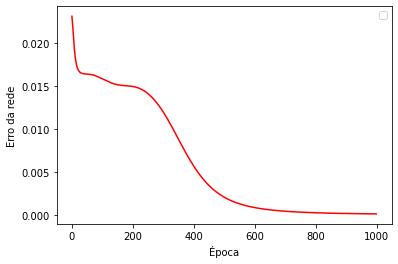

In [10]:
y = dadosTreinamento_iris
x = np.arange(0, len(y['erroRede']))

plt.plot(x, y['erroRede'], 'r')
plt.ylabel("Erro da rede")
plt.xlabel("Época")
plt.legend()

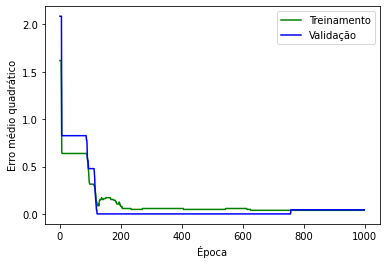

In [11]:
y = dadosTreinamento_iris
x = np.arange(0, len(y['erroRede']))

plt.plot(x, y['mseTre'], 'g-', label='Treinamento')
plt.plot(x, y['mseVal'], 'b-', label='Validação')
plt.ylabel("Erro médio quadrático")
plt.xlabel("Época")
plt.legend()

In [13]:
matriz_confusao_iris, mse = classificarDados(rede_iris, X_test, y_test)
matriz_confusao_iris

[[8, 0, 0], [0, 8, 0], [0, 0, 6]]

In [14]:
mse

0.0